In [1]:
import FinanceDataReader as fdr
fdr.__version__

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 한국거래소 상장종목 전체
# 용도 : 코드와 종목명 가져오기
df_krx = fdr.StockListing('KRX')

# 코스피 종목 추출
# 용도 : DataReader 사용시 종목별 기간 조회 건수가 상이하다.
#        코스피 데이터 날짜를 기준으로 가져오기 위해 사용
strt_dt = '2014-01-01' # 시작일 지정
end_dt = '2018-12-31'  # 종료일 지정
kospi_df = fdr.DataReader('KS11', strt_dt,end_dt)
kospi_df.reset_index(inplace = True)

In [4]:
kospi_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,2013.109985,2013.890015,1967.189941,1967.189941,1967.189941,207800.0
1,2014-01-03,1963.719971,1964.630005,1936.150024,1946.140015,1946.140015,188500.0
2,2014-01-06,1947.619995,1961.849976,1943.739990,1953.280029,1953.280029,193600.0
3,2014-01-07,1947.650024,1965.739990,1947.079956,1959.439941,1959.439941,193000.0
4,2014-01-08,1965.500000,1966.949951,1950.020020,1958.959961,1958.959961,217100.0


In [8]:
def stock_reader(kospi_df, code_list, n=0):

    if n == 0:
        n = len(code_list)

    stock_df = pd.DataFrame()
    stock_df['Date'] = kospi_df['Date']
    print("동기간 KOSPI 생성일수 : ", len(kospi_df['Date']))
    normal_cnt = 0
    err_cnt = 0
    code_nm_list = []

    for code in code_list:
        stock = df_krx[df_krx.Code == code]
        code_nm = list(stock.Name)[0]


        try:
            temp = fdr.DataReader(code, strt_dt, end_dt)

            # 데이터일수가 시장보다 작으면 skip(최근 상장 데이터로 판단)
            if len(temp) < len(kospi_df['Date']):
                err_cnt += 1
                print("skip : (",err_cnt,")", code, code_nm, strt_dt, end_dt, ", 건수 : ", len(temp))
                continue

            temp.reset_index(inplace = True)
            temp_df = pd.merge(temp[['Date','Close']], kospi_df[['Date']], on='Date', how='right')
            stock_df[code_nm] = temp_df.Close
            normal_cnt += 1
            code_nm_list.append(code_nm)
            print("정상 : (",normal_cnt,")", code, code_nm, strt_dt, end_dt, ", 건수 : ", len(temp), "->", len(stock_df))
        except:
            err_cnt += 1
            print("skip : (",err_cnt,")", code, code_nm, strt_dt, end_dt, ", 건수 : ", len(temp))

        if normal_cnt == n:
            print('총', n,'개 생성 설정 / ', normal_cnt, '개 생성 완료')
            break # n개 종목 생성시 종료

        # 데이터 정렬
        stock_df.sort_values('Date', ascending=True, inplace=True) # ascending=True 오름차순, False 내림차순
        # 결측치 채우기
        stock_df.fillna(method='ffill', inplace=True)

    return stock_df, code_nm_list

In [9]:
code_list = ['055550']
stock_df, code_nm_list = stock_reader(kospi_df, code_list)

동기간 KOSPI 생성일수 :  1225
정상 : ( 1 ) 055550 신한지주 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
총 1 개 생성 설정 /  1 개 생성 완료


In [11]:
stock_df.head(3)

,Date,신한지주
0,2014-01-02,46600.0
1,2014-01-03,44850.0
2,2014-01-06,45550.0


In [14]:
code_nm_list

['신한지주']

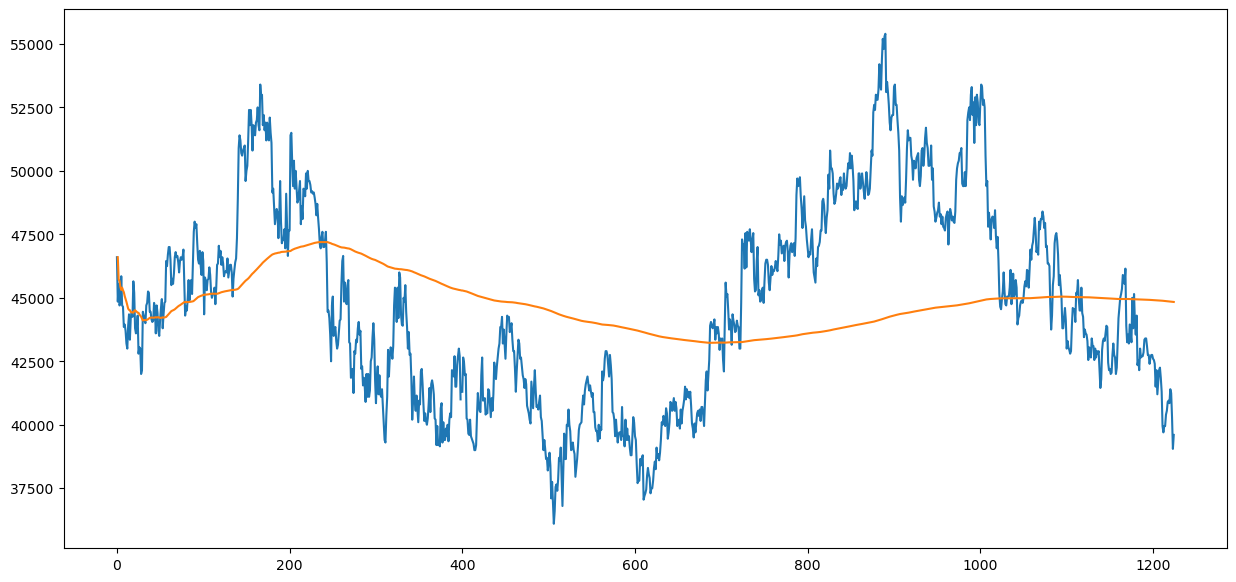

In [31]:
prices = pd.DataFrame(stock_df[code_nm_list[0]])

code_nm = code_nm_list[0]
prices['mu'] = [prices[code_nm][:i].mean() for i in range(len(prices))]

# Plot the price and the moving average
plt.figure(figsize=(15,7))
plt.plot(prices[code_nm])
plt.plot(prices['mu']);
plt.show()

In [32]:
prices

,신한지주,mu
0,46600.0,NaN
1,44850.0,46600.000000
2,45550.0,45725.000000
3,44700.0,45666.666667
4,44850.0,45425.000000
...,...,...
1220,41400.0,44851.599672
1221,41250.0,44848.770492
1222,40300.0,44845.823096
1223,39050.0,44842.103110


In [42]:
zscores = [(prices[code_nm][i] - prices['mu'][i]) / np.std(prices[code_nm][:i]) for i in range(len(prices))]

# Start with no money and no positions
money = 0
count = 0
results = {'Long' : {'date' : [], 'price' : []}, 'Short' : {'date' : [], 'price' : []}, 'Account' : []}
for i in range(len(prices)):
    # Sell short if the z-score is > 1
    if zscores[i] > 1:
        money += prices[code_nm][i]
        count -= 1
        results['Short']['date'].append(stock_df['Date'][i].date())
        results['Short']['price'].append(prices[code_nm][i])
        
    # Buy long if the z-score is < 1
    elif zscores[i] < -1:
        money -= prices[code_nm][i]
        count += 1
        results['Long']['date'].append(stock_df['Date'][i].date())
        results['Long']['price'].append(prices[code_nm][i])
    # Clear positions if the z-score between -.5 and .5
    elif abs(zscores[i]) < 0.5:
        money += count*prices[code_nm][i]
        count = 0
    
    results['Account'].append(money)
print(money)

1258800.0


C:\Users\kim56\AppData\Local\Temp\ipykernel_14848\2541494037.py:1: RuntimeWarning: divide by zero encountered in scalar divide
  zscores = [(prices[code_nm][i] - prices['mu'][i]) / np.std(prices[code_nm][:i]) for i in range(len(prices))]


<Figure size 1500x700 with 0 Axes>

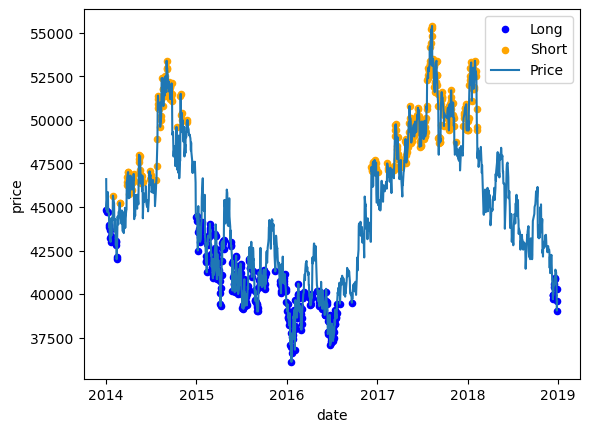

In [65]:
plt.figure(figsize=(15,7))
fig, ax = plt.subplots(1)


pd.DataFrame(results['Long']).plot.scatter('date', 'price', color = 'b',ax = ax)
pd.DataFrame(results['Short']).plot.scatter('date', 'price', color = 'orange',ax = ax)
plt.plot(stock_df['Date'],stock_df[code_nm])
plt.legend(['Long', 'Short', 'Price'])

plt.show()

<Axes: >

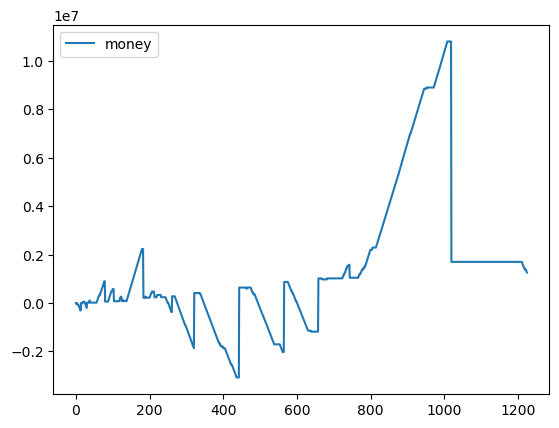

In [77]:
pd.DataFrame(results['Account'], columns = ['money']).plot()

In [78]:
n = 10 # 생성할 종목수 지정
df_krx_list = df_krx['Code'].head(n*2) # 임시로 2배까지 루프

stock_df, code_nm_list = stock_reader(kospi_df, df_krx_list, n)

동기간 KOSPI 생성일수 :  1225
정상 : ( 1 ) 005930 삼성전자 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
skip : ( 1 ) 373220 LG에너지솔루션 2014-01-01 2018-12-31 , 건수 :  0
정상 : ( 2 ) 000660 SK하이닉스 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
skip : ( 2 ) 207940 삼성바이오로직스 2014-01-01 2018-12-31 , 건수 :  523
정상 : ( 3 ) 005490 POSCO홀딩스 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
정상 : ( 4 ) 005935 삼성전자우 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
정상 : ( 5 ) 051910 LG화학 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
정상 : ( 6 ) 006400 삼성SDI 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
정상 : ( 7 ) 005380 현대차 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
정상 : ( 8 ) 035420 NAVER 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
정상 : ( 9 ) 003670 포스코퓨처엠 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
정상 : ( 10 ) 000270 기아 2014-01-01 2018-12-31 , 건수 :  1226 -> 1225
총 10 개 생성 설정 /  10 개 생성 완료


In [79]:
stock_df.set_index('Date', inplace=True)
data = stock_df
data.head(3)

,삼성전자,SK하이닉스,POSCO홀딩스,삼성전자우,LG화학,삼성SDI,현대차,NAVER,포스코퓨처엠,기아
Date,,,,,,,,,,
2014-01-02,26180.0,35550.0,322000.0,19780.0,292000.0,157500.0,224500.0,145205.0,11637.0,52700.0
2014-01-03,25920.0,36300.0,320500.0,19360.0,286000.0,153500.0,224000.0,139998.0,11712.0,52700.0
2014-01-06,26140.0,37650.0,316500.0,19740.0,284500.0,148000.0,228500.0,139998.0,11844.0,52500.0


Text(0, 0.5, 'Returns for the following month')

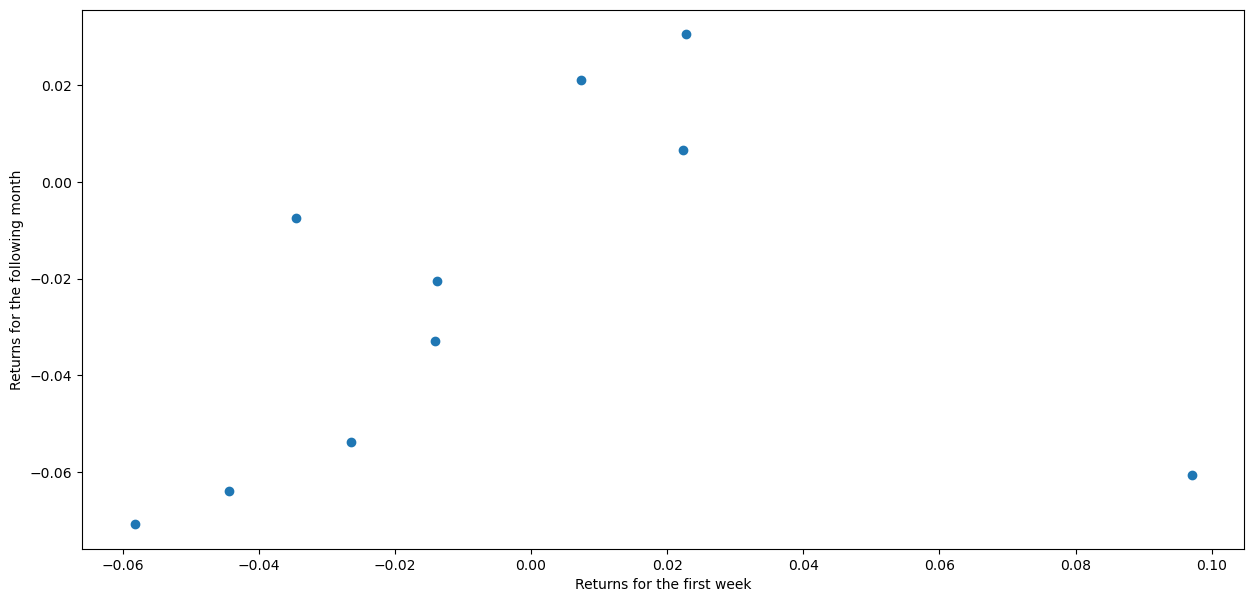

In [80]:
data = np.array(data)

# 첫 주의 수익률
wreturns = (data[4] - data[0])/data[0]  # 4일 = 1 weak
# Rank
order = wreturns.argsort()
ranks = order.argsort()

# 첫 주 이후, 한달 수익률
mreturns = (data[5+4*4] - data[5])/data[5]  # 첫주이후 5day, 한달 후 5일 + 4day*4weak
order2 = mreturns.argsort()
ranks2 = order2.argsort()

# Plot (가로 : 첫주 수익률, 세로 : 첫주 이후 한달 수익률)
plt.figure(figsize=(15,7))
plt.scatter(wreturns, mreturns)
plt.xlabel('Returns for the first week')
plt.ylabel('Returns for the following month')

In [81]:
# 비교할 종목간 첫주 수익률 기준으로 랭킹 top 20%, bottom 20%를 찾는다.
# ranks는 첫주 수익률 순위를 의미(낮을 수록 1, 낮은걸 long한다.)
# ranks는 첫주 이후 한달 수익률 순위를 의미

top_cnt = int(len(ranks) * 0.2)
bottom_cnt = int(len(ranks) * 0.8)

longs = np.array([int(x < top_cnt)for x in ranks])
shorts = np.array([int(x >= bottom_cnt) for x in ranks])
print('Going long in:', [code_nm_list[i] for i in range(len(code_nm_list)) if longs[i]])
print('Going short in:', [code_nm_list[i] for i in range(len(code_nm_list)) if shorts[i]])

# Resolve all positions and calculate how much we would have earned
print('Yield:', sum((data[-1] - data[4])*(longs - shorts)))

Going long in: ['LG화학', '삼성SDI']
Going short in: ['SK하이닉스', '기아']
Yield: 139200.0
